In [1]:
import pickle
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from langchain_community.chat_models import ChatOpenAI
from langchain_experimental.agents import create_pandas_dataframe_agent

import os
os.environ['OPENAI_API_KEY'] = "key"

# Read the complete MTA/QTL marker file for the 21 manuscripts

In [2]:
df = pd.read_csv("data_input/markers/all_QTL_markers_EP.txt", sep="\t")

# Prompt the LLMs to extract relevant data from curated results 

In [ ]:
for rep in [1,2,3]:
    for model in ["gpt-3.5-turbo-1106", "gpt-4"]:
        llm = ChatOpenAI(model_name=model)
        agent = create_pandas_dataframe_agent(llm, df, verbose=False)
        
        agent.run("""Identify all trait QTLs related to plant response to disease or disease resistance. \
                     Filter table to include only relevant traits and keep all columns. \
                     Write the results to data_output/extract/all.minimal.{}.{}.tsv""".format(rep, model))

        agent.run("""Identify all trait QTLs related to plant response to disease or disease resistance. \
                     Filter table to include only relevant traits and keep all columns. \
                     Write the results to data_output/extract/range.minimal.{}.{}.tsv""".format(rep, model))
        
        agent.run("""Identify all trait QTLs related to plant response to disease or disease resistance. \
                     To do this, check the unique values in the 'trait' column and guess based on your general knowledge. Use the 'chr', 'start', and 'end' columns to get information about the genomic location.
                     Filter table to include only relevant traits and keep all columns. \
                     Write the results to data_output/extract/all.knowledge.{}.{}.tsv""".format(rep, model))

        agent.run("""Identify all trait QTLs related to plant response to disease or disease resistance. \
                     To do this, check the unique values in the 'trait' column and guess based on your general knowledge. Use the 'chr', 'start', and 'end' columns to get information about the genomic location.
                     Range: Include only traits with QTLs located on chromosome 2B between 50mbp and 700mbp.
                     Filter table to include only relevant traits and keep all columns. \
                     Write the results to data_output/extract/range.knowledge.{}.{}.tsv""".format(rep, model))

# Plot results of extracted data

In [3]:
biotic_true = pd.read_csv("data_input/biotic_QTLs.tsv", sep="\t")
biotic_true = biotic_true[biotic_true["Biotic"]==1]
all_biotic_set = set(biotic_true["QTL"].tolist())
range_biotic_true = biotic_true[(biotic_true['Chr'] == 'chr2B') & (biotic_true['Start'] >= 50000000) & (biotic_true['End'] <= 700000000)]
range_biotic_set = set(range_biotic_true["QTL"].tolist())

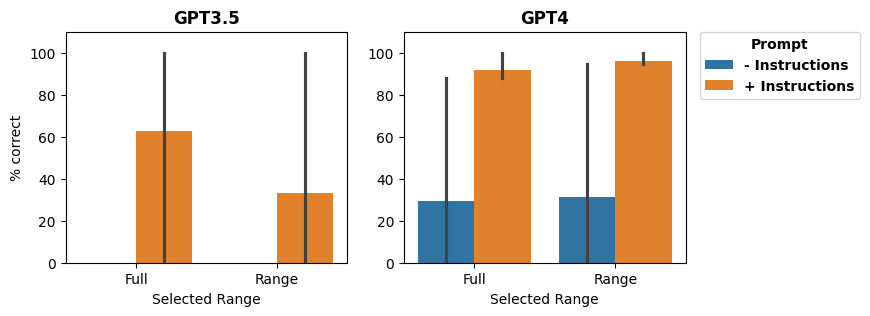

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharex=True)

plt.rcParams.update({'font.weight': 'bold', 'axes.labelweight': 'bold', 'axes.titleweight': 'bold'})

outputlist = []
for mode in ["minimal", "knowledge"]:
    for rep in [1,2,3]:
        for x in ["all", "range"]:
            if x == "all":
                true_set = all_biotic_set
            else:
                true_set = range_biotic_set
            output_df = pd.read_csv("data_output/extract/{}.{}.{}.gpt-4.tsv".format(x, mode, rep), sep="\t")
            if "QTL" in output_df.columns:
                output_set = set(output_df["QTL"].tolist())
            outputlist.append(["gpt4", mode, rep, x, 
                              len(output_set), 
                              np.round(len(output_set.intersection(true_set)) / len(true_set) * 100, 2),
                              len(output_set.difference(true_set))])
outputlist = pd.DataFrame(outputlist)
outputlist.columns = ["model", "Prompt", "rep", "Selected Range", "len_out", "% correct", "# incorrect"]
mapping = {"minimal": '- Instructions', "knowledge": '+ Instructions', "all": "Full", "range":"Range"}
outputlist = outputlist.replace(mapping)

ax1 = sns.barplot(data=outputlist, x="Selected Range", y="% correct", hue="Prompt", ax=ax[1])
ax[1].set_ylim([0,110])
ax1.get_legend().remove()
ax1.set_title("GPT4")
ax1.set_ylabel("")

outputlist = []
for mode in ["minimal", "knowledge"]:
    for rep in [1,2,3]:
        for x in ["all", "range"]:
            if x == "all":
                true_set = all_biotic_set
            else:
                true_set = range_biotic_set
            output_df = pd.read_csv("data_output/extract/{}.{}.{}.gpt-3.5-turbo-1106.tsv".format(x, mode, rep), sep="\t")
            if "QTL" in output_df.columns:
                output_set = set(output_df["QTL"].tolist())
            outputlist.append(["gpt3.5", mode, rep, x, 
                              len(output_set), 
                              np.round(len(output_set.intersection(true_set)) / len(true_set) * 100, 2),
                              len(output_set.difference(true_set))])
outputlist = pd.DataFrame(outputlist)
outputlist.columns = ["model", "Prompt", "rep", "Selected Range", "len_out", "% correct", "# incorrect"]
mapping = {"minimal": 'Minimal', "knowledge": 'Instructions', "all": "Full", "range":"Range"}
outputlist = outputlist.replace(mapping)

ax2 = sns.barplot(data=outputlist, x="Selected Range", y="% correct", hue="Prompt", ax=ax[0])
ax[0].set_ylim([0,110])
ax2.set_title("GPT3.5")
ax2.get_legend().remove()
ax2.set_ylabel("% correct")

ax1.legend(title="Prompt", prop={'size': 10},
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()